In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import pdist, squareform
import plotly.offline as py
from tqdm import tqdm
from sklearn.decomposition import PCA

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)
df_merged_clusterB = pd.read_hdf('../../ds/cleaned/reduced_for_clustering.h5')
df_merged_clusterB.head()

,date,state,city_or_county,latitude,longitude,congressional_district,participant_age_group1,participant_gender1,avg_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,incident_characteristics1,povertyPercentage,party,candidatevotes,totalvotes,ratio_killed,death_level,percentage_injured,unharmed_ratio,density_incident_state,males_to_females_ratio
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,Adult 18+,Male,26,0,0,0,0,1,0,1,Shot - Wounded/Injured,16.8,REPUBLICAN,110789.0,206131.0,0.0,No deaths,58.789954,2.345189,0.136149,2.0
1,2014-01-01,California,Bakersfield,35.3229,-119.0380,23,Adult 18+,Male,28,0,0,0,0,2,0,0,Shot - Wounded/Injured,14.5,REPUBLICAN,100317.0,134043.0,0.0,No deaths,45.310907,2.345189,0.639968,2.0
2,2014-01-01,Iowa,Iowa City,41.6611,-91.5302,2,Adult 18+,Female,35,0,0,2,0,1,0,1,other,10.1,DEMOCRAT,143431.0,273329.0,0.0,No deaths,71.662763,2.345189,0.096973,0.0
3,2014-01-01,New York,Brooklyn,40.6505,-73.9573,9,Adult 18+,Male,29,0,0,1,0,3,0,0,Shot - Wounded/Injured,13.4,DEMOCRAT,70997.0,101606.0,0.0,No deaths,70.237122,2.345189,0.534650,2.0
4,2014-01-01,Colorado,Grand Junction,39.0496,-108.5250,3,Adult 18+,Male,47,0,0,0,1,0,0,0,"Shot - Dead (murder, accidental, suicide)",10.2,REPUBLICAN,163011.0,281141.0,1.0,All deaths,43.229167,2.345189,0.097775,1.0


# Density-based clustering

DBSCAN: start from data distribution, count #points close to each point, like a circle and overlap. Define a core points: es a point that is close to at least n points (defined by user), randomly pick a core point, assign it to a cluster. Others core points close to the 1st cluster are added (cuz the circle overlap them), go on... then add non-core point if just is close to a core point


# Define a newgranular feaure accordind to disctrics since we're dealing with a state: average incident density per district

In [125]:

# define new indicator variable
df_merged_clusterB['avg_incident_density_per_district'] = df_merged_clusterB.groupby('congressional_district')['density_incident_state'].transform('mean') #avg

#convert death_level to numeric for clustering
df_merged_clusterB['death_level'] = df_merged_clusterB['death_level'].map({'No deaths': 0, 'Some deaths': 1, 'All deaths': 2})
df_merged_clusterB.head()


,date,state,city_or_county,latitude,longitude,congressional_district,participant_age_group1,participant_gender1,avg_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,incident_characteristics1,povertyPercentage,party,candidatevotes,totalvotes,ratio_killed,death_level,percentage_injured,unharmed_ratio,density_incident_state,males_to_females_ratio,avg_incident_density_per_district
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,Adult 18+,Male,26,0,0,0,0,1,0,1,Shot - Wounded/Injured,16.8,REPUBLICAN,110789.0,206131.0,0.0,0,58.789954,2.345189,0.136149,2.0,0.332950
1,2014-01-01,California,Bakersfield,35.3229,-119.0380,23,Adult 18+,Male,28,0,0,0,0,2,0,0,Shot - Wounded/Injured,14.5,REPUBLICAN,100317.0,134043.0,0.0,0,45.310907,2.345189,0.639968,2.0,0.593119
2,2014-01-01,Iowa,Iowa City,41.6611,-91.5302,2,Adult 18+,Female,35,0,0,2,0,1,0,1,other,10.1,DEMOCRAT,143431.0,273329.0,0.0,0,71.662763,2.345189,0.096973,0.0,0.316859
3,2014-01-01,New York,Brooklyn,40.6505,-73.9573,9,Adult 18+,Male,29,0,0,1,0,3,0,0,Shot - Wounded/Injured,13.4,DEMOCRAT,70997.0,101606.0,0.0,0,70.237122,2.345189,0.534650,2.0,0.416183
4,2014-01-01,Colorado,Grand Junction,39.0496,-108.5250,3,Adult 18+,Male,47,0,0,0,1,0,0,0,"Shot - Dead (murder, accidental, suicide)",10.2,REPUBLICAN,163011.0,281141.0,1.0,2,43.229167,2.345189,0.097775,1.0,0.271355


In [126]:
# show all different values for death_level 
df_merged_clusterB['death_level'].unique()

[0, 2, 1]
Categories (3, int64): [0 < 1 < 2]

# Condider TEXAS since is the state with more weapons

In [127]:
#select column for dbscan
col_clustering_dbscan = ['avg_age_participants','avg_incident_density_per_district','congressional_district','death_level'] 

#take only the columns for dbscan
df_for_dbscan = df_merged_clusterB[col_clustering_dbscan]

#dataframe with onlyt Texas
df_texas =  df_merged_clusterB[df_merged_clusterB['state'] == 'Texas']

#dataframe about Texas with only the columns for dbscan
df_texas_clustering = df_texas[col_clustering_dbscan]

# Standardizzazione dei dati
scaler = StandardScaler()
df_texas_scaled = scaler.fit_transform(df_texas_clustering)

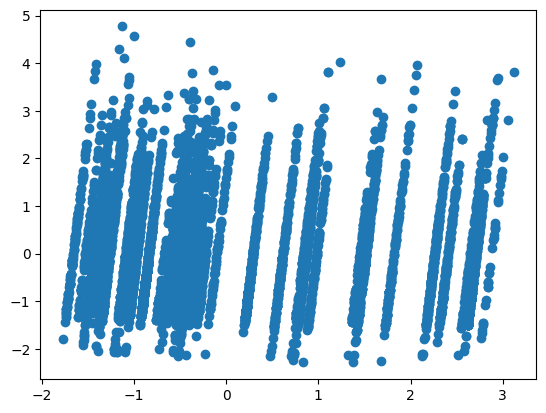

In [128]:
#pca on the new df

pca = PCA(n_components=2)
df_texas_pca = pca.fit_transform(df_texas_scaled)
plt.scatter(df_texas_pca[:,0], df_texas_pca[:,1])

# knee points

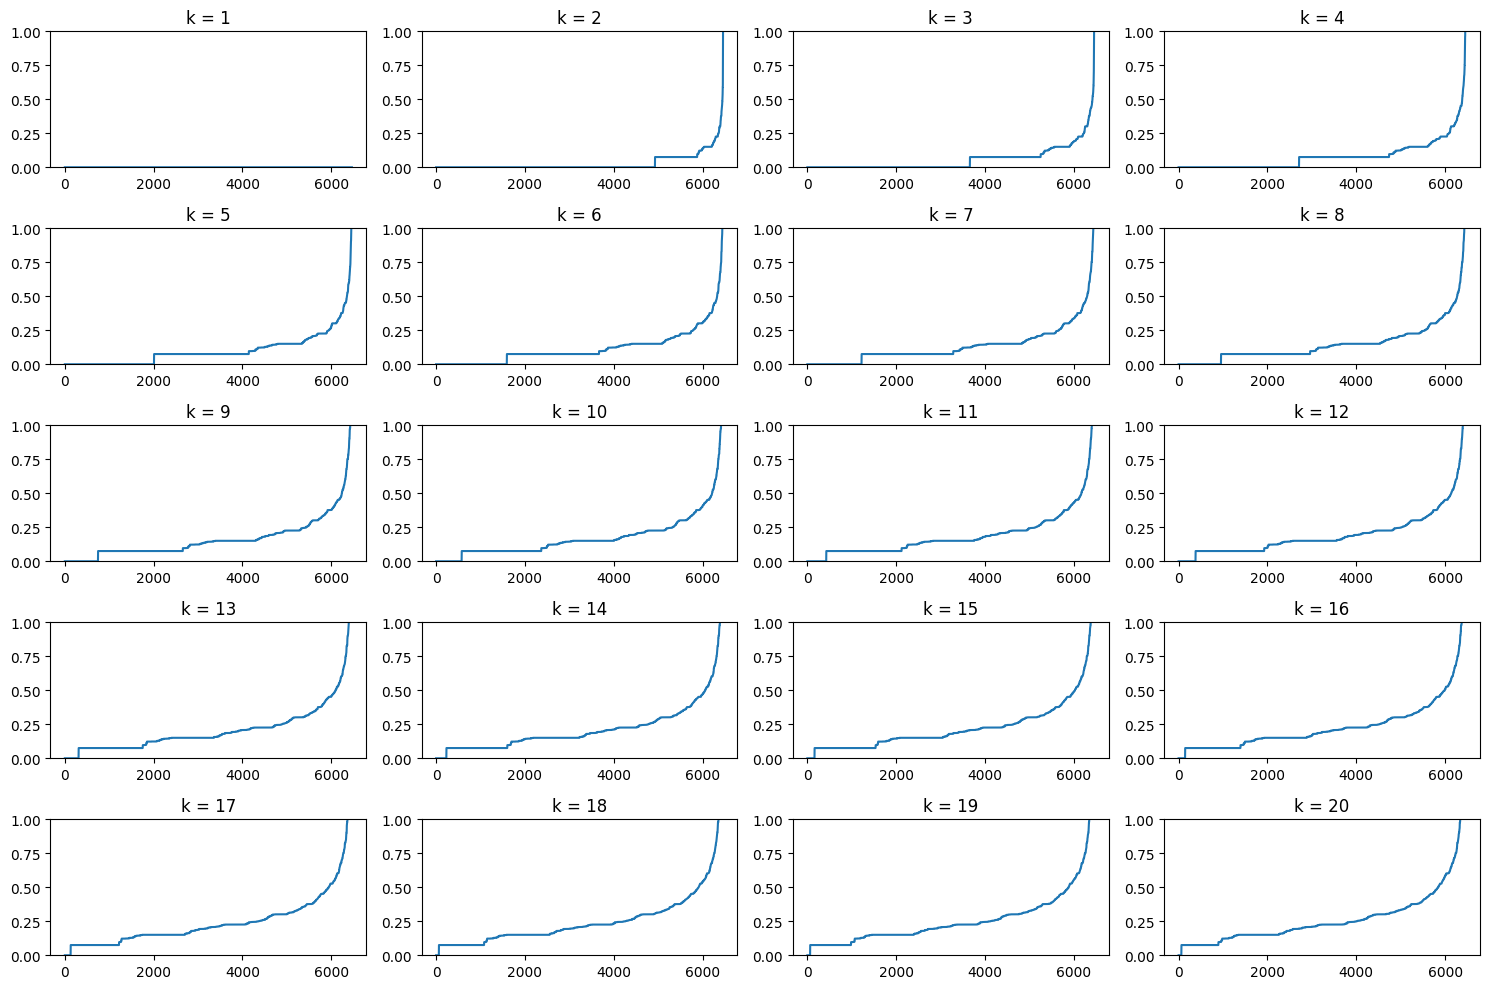

In [129]:
from sklearn.neighbors import NearestNeighbors
max_k = 20
nbrs = NearestNeighbors(n_neighbors=max_k).fit(df_texas_scaled)
fig , ax = plt.subplots(5, 4, figsize=(15,10))
for k in range(max_k):
    distances, indices = nbrs.kneighbors(df_texas_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k]
    ax[k//4, k%4].plot(distances)
    ax[k//4, k%4].set_title('k = {}'.format(k+1))
    ax[k//4, k%4].set_ylim([0, 1])
plt.tight_layout()

In [130]:
#try to fit dbscan with different values of eps and min_samples by looking at the curves
dbscan= DBSCAN(eps=0.25, min_samples=10).fit(df_texas_scaled)
df_texas['cluster_dbscan'] = dbscan.labels_
df_texas['cluster_dbscan'].value_counts()

/tmp/ipykernel_48640/2787583007.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster_dbscan
 1     1980
 0     1074
-1      752
 3      554
 7      423
 10     220
 4      187
 6      139
 17     131
 15     119
 12     106
 16     104
 11      91
 8       70
 13      66
 19      48
 5       43
 29      39
 9       32
 25      27
 18      23
 2       22
 20      21
 22      20
 21      19
 32      18
 31      16
 26      16
 28      15
 33      12
 23      12
 14      11
 27      11
 35      10
 24      10
 30       9
 36       9
 34       5
Name: count, dtype: int64

In [131]:
# more fine grained analysis

def calc_k_nn_dist_graph(X):
    
    # List of k (for k-th nearest neighbour)
    k_list = [3, 6, 9, 12]

    dist = pdist(X, 'euclidean') # pair wise distance
    dist = squareform(dist) #distance matrix given the vector dist
    
    # Calculate sorted list of distances for points for each k
    for k in k_list:
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])

        # Plot the graph of distance from k-th nearest neighbour
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
        plt.xlabel('sorted distances', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=22)
        plt.grid()
        f = plt.figure()
        f.set_figwidth(4)
        f.set_figheight(1)
        plt.show()

In [132]:
#prepare function for grid searching

def db_scan_function (X, eps_list, minpts_list, max_iter_value=300):
    
    # Table with dim = len(eps_list) x len(minpts)
    dbscan_table = list()

    # Iterate over eps (rows)
    for i, eps in tqdm(enumerate(eps_list)):
        dbscan_table.append([]) 
        # Iterate over minpts
        for minpts in tqdm(minpts_list, leave=False):
            dbscan = DBSCAN(eps=eps, min_samples=minpts, n_jobs=-1)
            dbscan.fit(X)
            dbscan_table[i].append(dbscan)
    
    return dbscan_table

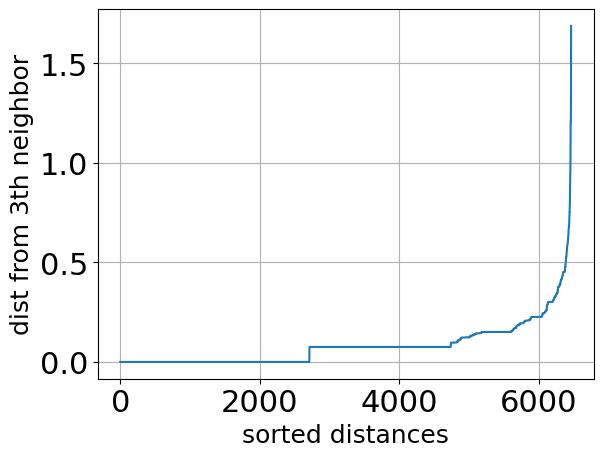

<Figure size 400x100 with 0 Axes>

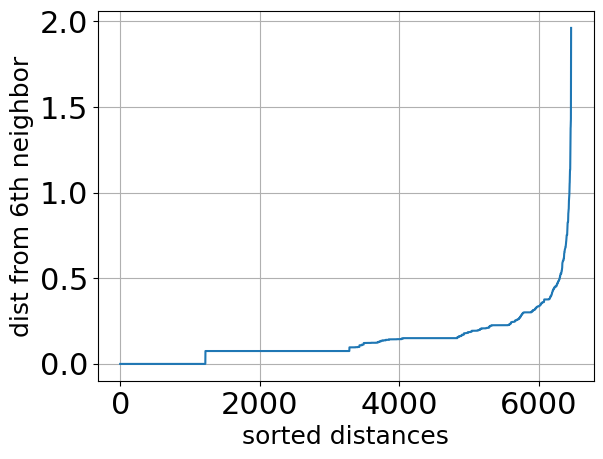

<Figure size 400x100 with 0 Axes>

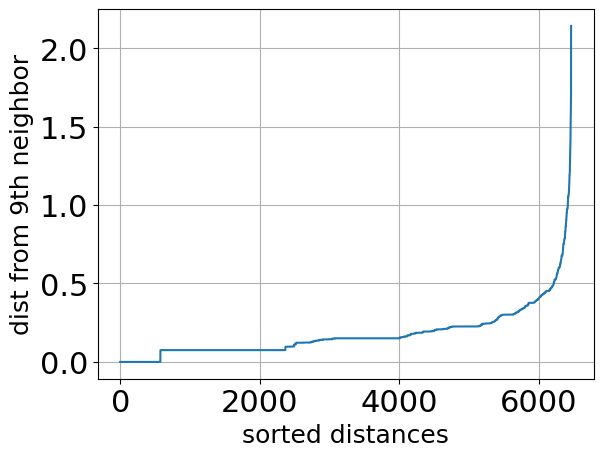

<Figure size 400x100 with 0 Axes>

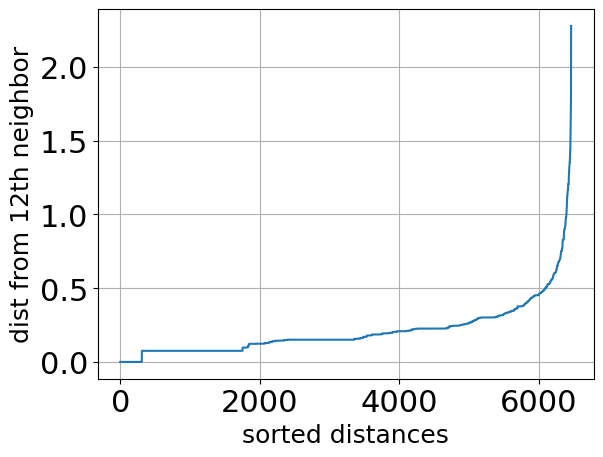

<Figure size 400x100 with 0 Axes>

In [133]:
calc_k_nn_dist_graph(df_texas_scaled)

# grid search

In [134]:
# parameters for grid search
eps_list = [0.2, 0.3, 0.4, 0.5, 0.6] 
minpts_list = [5, 10, 15]

# Table with fitted dbscans (rows are eps values, cols are minpts values)
dbscan_table = db_scan_function(df_texas_scaled, eps_list, minpts_list)

5it [00:01,  3.86it/s]


In [135]:
from prettytable import PrettyTable
from sklearn.metrics import silhouette_score

# define a table for grid search results: score - n_clusters for different eps and minpts
t = PrettyTable()
t.field_names = ['eps\minpts'] + minpts_list

for i, eps in tqdm(enumerate(eps_list)):
    row_str = [str(eps)]
    for j, minpts  in tqdm(enumerate(minpts_list), leave=False):
        dbscan = dbscan_table[i][j]

        try: # Exception in case of num_clusters=1
            silhouette = round(silhouette_score(df_texas_scaled, dbscan.labels_), 2)
        except:
            silhouette = np.nan
        cell_str = str(silhouette) + '-n_clust:'+str(len(np.unique(dbscan.labels_))-1)
        row_str.append(cell_str)

    t.add_row(row_str)

print('Results \n')
print(t)

5it [00:08,  1.63s/it]

Results 

+------------+------------------+-----------------+------------------+
| eps\minpts |        5         |        10       |        15        |
+------------+------------------+-----------------+------------------+
|    0.2     | -0.08-n_clust:89 | -0.1-n_clust:60 | -0.16-n_clust:36 |
|    0.3     | 0.05-n_clust:51  | 0.04-n_clust:33 | 0.06-n_clust:25  |
|    0.4     | 0.13-n_clust:27  | 0.15-n_clust:25 | 0.16-n_clust:21  |
|    0.5     | 0.21-n_clust:12  |  0.24-n_clust:9 |  0.24-n_clust:8  |
|    0.6     |  0.13-n_clust:6  |  0.12-n_clust:6 |  0.13-n_clust:5  |
+------------+------------------+-----------------+------------------+


In [136]:
# run dbsc with beast score

dbscan= DBSCAN(eps=0.5, min_samples=10).fit(df_texas_scaled)
df_texas['cluster_dbscan'] = dbscan.labels_
df_texas['cluster_dbscan'].value_counts()

/tmp/ipykernel_48640/2883629937.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster_dbscan
 1    2656
 0    1383
 2     779
 4     662
 5     436
 6     239
 3     144
-1     126
 7      25
 8      14
Name: count, dtype: int64

In [137]:
print('count of elements for each cluster\n')

for i, eps in enumerate(eps_list):
    for j, minpts  in enumerate(minpts_list):
        dbscan = dbscan_table[i][j]
        n_clusters = len(np.unique(dbscan.labels_))-1 # -1 to exclude outlier label
        occ_list = []
        for k in range(-1, n_clusters):
             occ_list.append(np.count_nonzero(dbscan.labels_ == k))
        print('eps:', eps, ', minpts:', minpts, '-', occ_list)

count of elements for each cluster

eps: 0.2 , minpts: 5 - [618, 661, 1409, 119, 6, 23, 322, 185, 45, 292, 141, 25, 181, 69, 209, 237, 68, 14, 214, 33, 116, 176, 32, 111, 6, 105, 67, 9, 103, 25, 147, 39, 15, 7, 48, 21, 59, 15, 6, 10, 14, 10, 7, 22, 7, 13, 10, 14, 10, 6, 16, 23, 5, 5, 8, 14, 16, 10, 5, 5, 41, 28, 9, 8, 7, 5, 6, 8, 12, 11, 6, 6, 7, 8, 9, 10, 5, 6, 3, 6, 5, 4, 5, 5, 9, 7, 4, 5, 5, 6]
eps: 0.2 , minpts: 10 - [1386, 228, 1342, 183, 37, 264, 134, 374, 181, 68, 221, 199, 220, 42, 212, 112, 162, 27, 93, 28, 83, 16, 41, 21, 5, 99, 91, 126, 18, 10, 19, 18, 17, 21, 12, 24, 10, 20, 36, 16, 14, 21, 17, 22, 12, 14, 21, 7, 13, 8, 13, 9, 10, 10, 8, 6, 9, 10, 8, 10, 6]
eps: 0.2 , minpts: 15 - [2216, 190, 1274, 183, 22, 262, 132, 322, 181, 150, 191, 209, 185, 139, 22, 72, 21, 25, 48, 85, 91, 124, 17, 22, 45, 35, 22, 17, 15, 16, 31, 26, 18, 11, 18, 12, 15]
eps: 0.3 , minpts: 5 - [307, 1130, 2078, 120, 33, 52, 613, 201, 47, 142, 26, 438, 70, 35, 36, 235, 107, 123, 5, 112, 67, 13, 149, 48,

In [138]:
# grid search result eps: 0.5 , minpts: 10 - [126, 1383, 2656, 779, 144, 662, 436, 239, 25, 14]
dbscan= DBSCAN(eps=0.5, min_samples=10).fit(df_texas_scaled)
df_texas['cluster_dbscan'] = dbscan.labels_
df_texas['cluster_dbscan'].value_counts()

/tmp/ipykernel_48640/2423070765.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster_dbscan
 1    2656
 0    1383
 2     779
 4     662
 5     436
 6     239
 3     144
-1     126
 7      25
 8      14
Name: count, dtype: int64

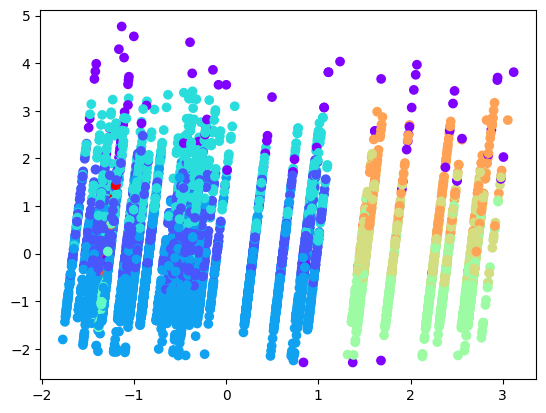

In [139]:
plt.scatter(df_texas_pca[:,0], df_texas_pca[:,1], c=df_texas['cluster_dbscan'], cmap='rainbow')

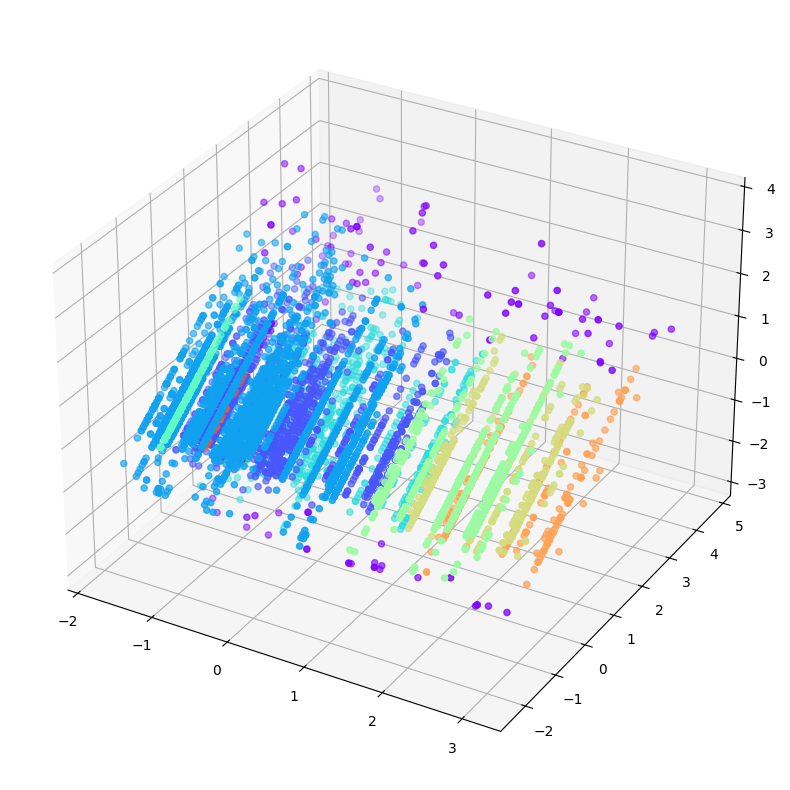

In [140]:
#plot 3d
pca= PCA(n_components=3)
df_texas_pca = pca.fit_transform(df_texas_scaled)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_texas_pca[:,0], df_texas_pca[:,1], df_texas_pca[:,2], c=df_texas['cluster_dbscan'], cmap='rainbow')

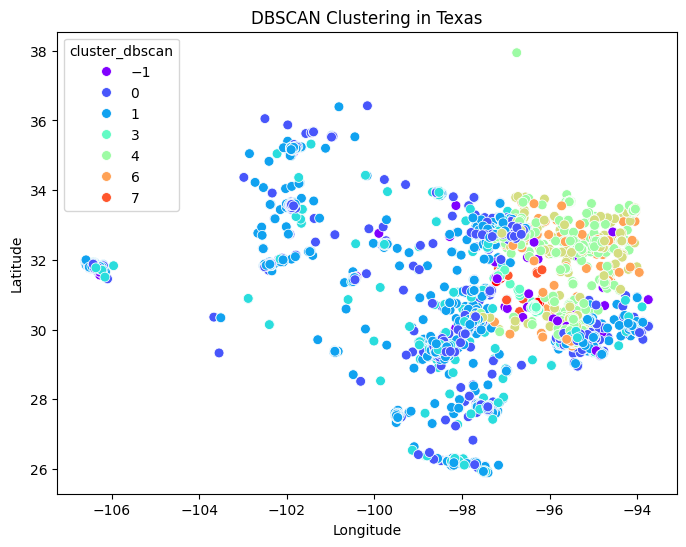

In [141]:
# plot dbsca result according to latitude and longitude
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', hue='cluster_dbscan', data=df_texas, palette='rainbow', s=50)
plt.title('DBSCAN Clustering in Texas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

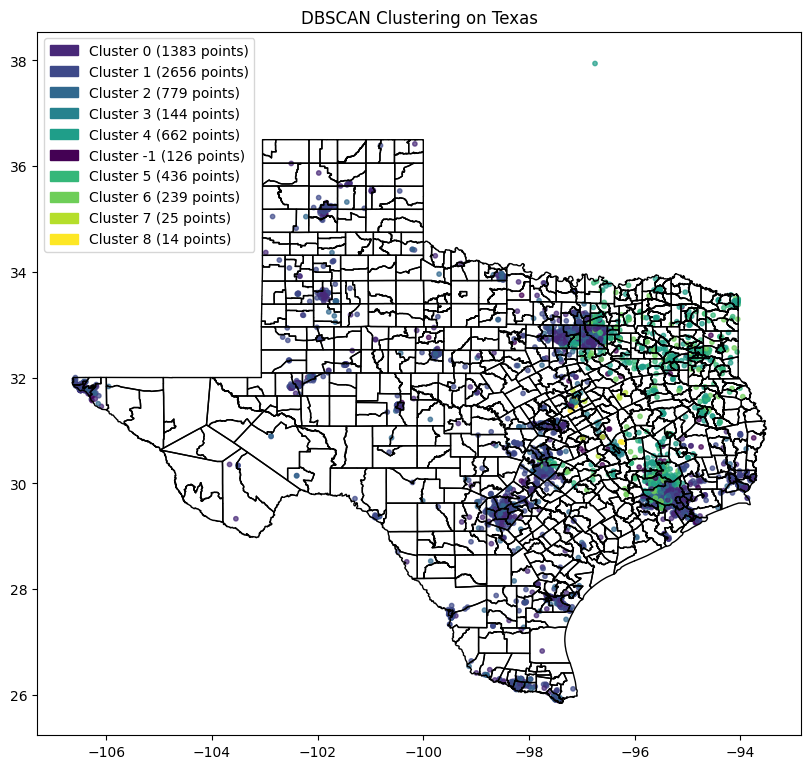

In [142]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd

# Load the shapefile of Texas
texas_shapefile = '../../map_data/texas_shape.shp'
texas_map = gpd.read_file(texas_shapefile)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)

# Get the unique clusters
clusters = df_texas['cluster_dbscan'].unique()

# Create a colormap
cmap = plt.cm.viridis

# Restrict only to Illinois state
df_merged_clustering = df_texas[df_texas['state'] == 'Texas']

# Normalize the colormap
norm = plt.Normalize(df_texas['cluster_dbscan'].min(), df_texas['cluster_dbscan'].max())

# Create a scatter plot
sc = plt.scatter(df_texas['longitude'][:6464], df_texas['latitude'][:6464],
                 c=df_texas['cluster_dbscan'][:6464], cmap='viridis', s=10, alpha=0.7)

# Plot the Illinois state boundaries
texas_map.plot(ax=plt.gca(), color='none', edgecolor='black')

# Calculate cluster sizes
cluster_sizes = df_texas['cluster_dbscan'].value_counts()

# Create a list of patches for the legend including cluster size
patches = [mpatches.Patch(color=cmap(norm(cluster)), label=f'Cluster {cluster} ({cluster_sizes[cluster]} points)') for cluster in clusters]

# Add the legend to the plot
plt.legend(handles=patches)

plt.title('DBSCAN Clustering on Texas')
plt.tight_layout()
plt.show()

Clusters reflect the population density, according to the big cities: incidents follow the population density 

Silhouette Score: 0.23592074474604594


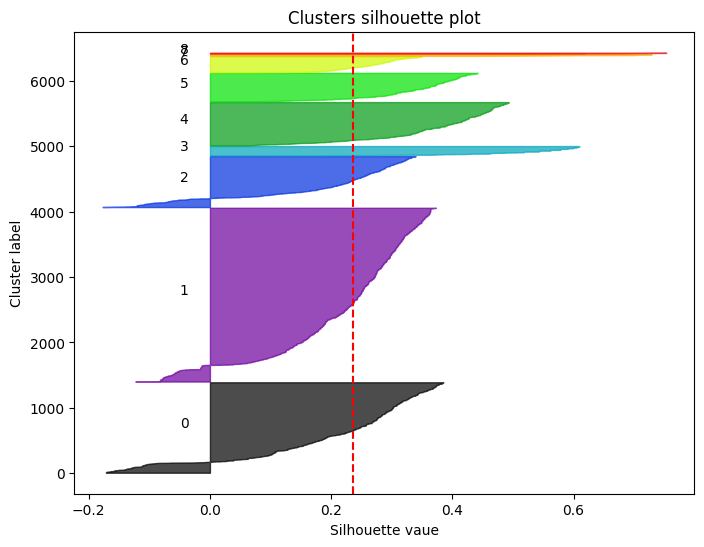

In [143]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# silhouette score shape
labels = df_texas['cluster_dbscan']

#avg score
silhouette_avg = silhouette_score(df_texas_scaled, labels)
print("Silhouette Score:", silhouette_avg)

# Calcola la silhouette score per ogni campione
sample_silhouette_values = silhouette_samples(df_texas_scaled, labels)

# plot silhouette 
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10

# Loop through each cluster label
for i in range(max(labels) + 1):
    
    # Extract silhouette values for each data point in the current cluster
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    
    # Sort silhouette values in ascending order
    ith_cluster_silhouette_values.sort()
    
    # Calculate the size of the current cluster
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    
    # Define upper and lower y-values for the cluster's silhouette plot
    y_upper = y_lower + size_cluster_i

    # unique color for the current cluster
    color = cm.nipy_spectral(float(i) / (max(labels) + 1))
    
    # Fill the area between y_lower and y_upper with the silhouette values
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Add cluster labels as text annotations
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Update y_lower for the next cluster plot, adding a small gap between clusters
    y_lower = y_upper + 10

ax.set_title("Clusters silhouette plot")
ax.set_xlabel("Silhouette vaue")
ax.set_ylabel("Cluster label")

# avg silhouette score (red dotted line)) 
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.show()

# PYCLUSTERING

In [144]:
import numpy as np

print("Versione di NumPy:", np.__version__)

Versione di NumPy: 1.23.5


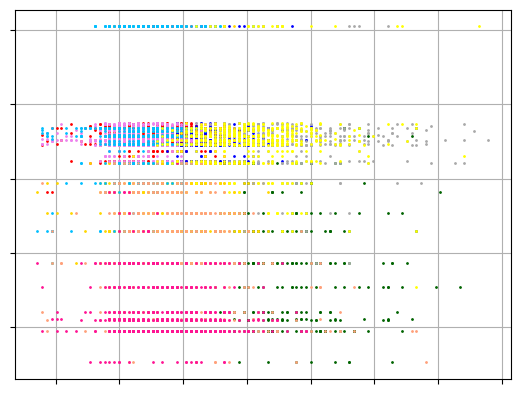

Numero totale di cluster: 10
Cluster 0: 1222 elementi
Caratteristiche del cluster:
                                date     latitude    longitude  \
count                           1222  1222.000000  1222.000000   
mean   2016-01-24 17:20:31.423895296    30.739065   -97.558551   
min              2014-01-01 00:00:00    25.894100  -106.554000   
25%              2015-01-07 06:00:00    29.509925   -98.423775   
50%              2016-01-28 12:00:00    30.004650   -97.291400   
75%              2017-01-30 18:00:00    32.704500   -96.642425   
max              2018-03-31 00:00:00    36.050600   -93.836100   
std                              NaN     1.807430     2.118998   

       congressional_district  avg_age_participants  n_participants_child  \
count             1222.000000           1222.000000           1222.000000   
mean                26.168576             25.617021              0.037643   
min                  7.000000              2.000000              0.000000   
25%           

In [145]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.mbsas import mbsas
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
import warnings
np.warnings = warnings

# Parametri per MBSAS
threshold = 0.6  # soglia di distanza
min_cluster_size = 5  # numero minimo di elementi in un cluster
sample_size = 10  # numero di campioni da utilizzare per la creazione di cluster iniziale

# Inizializza i cluster usando K-Means++
initial_centers = kmeans_plusplus_initializer(df_mississippi_scaled, sample_size).initialize()

# Crea un'istanza di MBSAS
mbsas_instance = mbsas(df_mississippi_scaled, len(initial_centers), threshold, min_cluster_size)
mbsas_instance.process()

# Ottieni i risultati del clustering
clusters = mbsas_instance.get_clusters()

# Trova i punti di rumore (punti non assegnati a nessun cluster)
noise_indices = [point_index for cluster in clusters for point_index in cluster]
all_points = set(range(len(df_mississippi_scaled)))
noise_indices = list(all_points - set(noise_indices))


# Visualizza i cluster utilizzando PCA
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, df_mississippi_scaled[:, 0:2], markersize=2)
visualizer.append_cluster(noise_indices, df_mississippi_scaled[:, 0:2], marker='x', markersize=5)
visualizer.show()

# Stampa informazioni sui singoli cluster
print(f"Numero totale di cluster: {len(clusters)}")

for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} elementi")
    print(f"Caratteristiche del cluster:")
    print(df_mississippi.iloc[cluster].describe())
    print("\n")

# Stampa informazioni sul rumore
print(f"Cluster NOISE (outlier): {len(noise_indices)} elementi")

In [146]:
df_merged_clusterB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131618 entries, 0 to 134578
Data columns (total 28 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   date                               131618 non-null  datetime64[ns]
 1   state                              131618 non-null  object        
 2   city_or_county                     131618 non-null  object        
 3   latitude                           131618 non-null  float64       
 4   longitude                          131618 non-null  float64       
 5   congressional_district             131618 non-null  int64         
 6   participant_age_group1             131618 non-null  category      
 7   participant_gender1                131618 non-null  category      
 8   avg_age_participants               131618 non-null  int64         
 9   n_participants_child               131618 non-null  int64         
 10  n_participants_teen      

KeyboardInterrupt: 

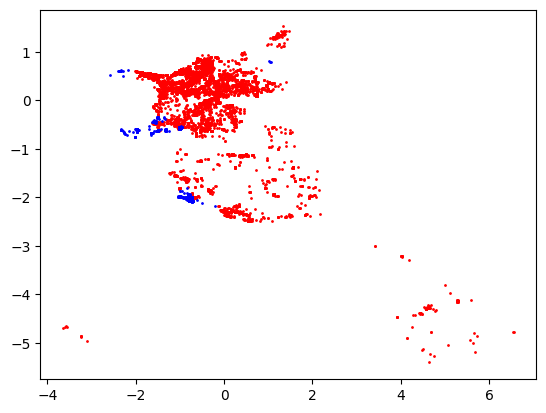

In [147]:
from pyclustering.cluster import cluster_visualizer, mbsas
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.mbsas import mbsas as MBSAS

# Seleziona colonne rilevanti
col_clustering_mbsas = ['percentage_injured', 'avg_incident_density_per_district', 'congressional_district', 'unharmed_ratio', 'males_to_females_ratio', 'povertyPercentage', 'avg_age_participants', 'latitude', 'longitude']

# Crea un DataFrame con le colonne selezionate
df_for_mbsas = df_merged_clusterB[col_clustering_mbsas]

# Standardizzazione dei dati
scaler = StandardScaler()
df_for_mbsas_scaled = scaler.fit_transform(df_for_mbsas)

# Parametri per MBSAS
threshold = 0.6  # soglia di distanza
min_cluster_size = 10  # numero minimo di elementi in un cluster
sample_size = 15 # numero di campioni da utilizzare per la creazione di cluster iniziale

# Inizializza i cluster usando K-Means++
initial_centers = kmeans_plusplus_initializer(df_for_mbsas_scaled[:, -2:], sample_size).initialize()  # Usiamo solo le colonne 'latitude' e 'longitude'

# Crea un'istanza di MBSAS
mbsas_instance = MBSAS(df_for_mbsas_scaled[:, :-2], len(initial_centers), threshold, min_cluster_size)  # Escludi le colonne 'latitude' e 'longitude'
mbsas_instance.process()

# Ottieni i risultati del clustering
clusters = mbsas_instance.get_clusters()

# Visualizza i cluster utilizzando PCA
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, df_for_mbsas_scaled[:, -2:], markersize=2)  # Usa solo le colonne 'latitude' e 'longitude' per la visualizzazione
visualizer.show()

# Stampa informazioni sui singoli cluster
print(f"Numero totale di cluster: {len(clusters)}")

for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} elementi")
    print(f"Caratteristiche del cluster:")
    print(df_for_mbsas.iloc[cluster].describe())
    print("\n")


using distance metric, work on numerical features we remove the categorical data

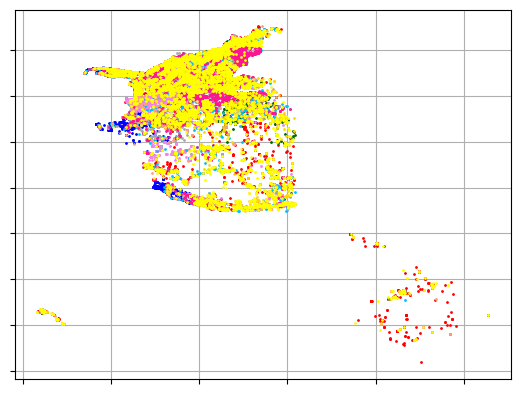

Numero totale di cluster: 10
Cluster 0: 16226 elementi
Caratteristiche del cluster:
       percentage_injured  avg_incident_density_per_district  \
count        16226.000000                       16226.000000   
mean            49.559815                        5995.040468   
std              6.771190                        1058.411546   
min             34.816248                        1684.466151   
25%             45.310907                        5324.818169   
50%             48.335855                        6575.057090   
75%             55.471192                        6683.623326   
max             65.822785                        6683.623326   

       congressional_district  unharmed_ratio  males_to_females_ratio  \
count            16226.000000    16226.000000            16226.000000   
mean                 2.642056        7.454421                1.407196   
std                  2.263301        2.754556                0.652697   
min                  1.000000        2.345189  

In [ ]:
from pyclustering.cluster import cluster_visualizer, mbsas
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.mbsas import mbsas as MBSAS

# Seleziona colonne rilevanti
col_clustering_mbsas = ['percentage_injured', 'avg_incident_density_per_district', 'congressional_district', 'unharmed_ratio', 'males_to_females_ratio', 'povertyPercentage', 'avg_age_participants', 'latitude', 'longitude']

# Crea un DataFrame con le colonne selezionate
df_for_mbsas = df_merged_clusterB[col_clustering_mbsas]

# Standardizzazione dei dati
scaler = StandardScaler()
df_for_mbsas_scaled = scaler.fit_transform(df_for_mbsas)

# Parametri per MBSAS
threshold = 0.6  # soglia di distanza
min_cluster_size = 5  # numero minimo di elementi in un cluster
sample_size = 10  # numero di campioni da utilizzare per la creazione di cluster iniziale

# Inizializza i cluster usando K-Means++
initial_centers = kmeans_plusplus_initializer(df_for_mbsas_scaled[:, -2:], sample_size).initialize()  # Usiamo solo le colonne 'latitude' e 'longitude'

# Crea un'istanza di MBSAS
mbsas_instance = MBSAS(df_for_mbsas_scaled[:, :-2], len(initial_centers), threshold, min_cluster_size)  # Escludi le colonne 'latitude' e 'longitude'
mbsas_instance.process()

# Ottieni i risultati del clustering
clusters = mbsas_instance.get_clusters()

# Visualizza i cluster utilizzando PCA
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, df_for_mbsas_scaled[:, -2:], markersize=2)  # Usa solo le colonne 'latitude' e 'longitude' per la visualizzazione
visualizer.show()

# Stampa informazioni sui singoli cluster
print(f"Numero totale di cluster: {len(clusters)}")

for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} elementi")
    print(f"Caratteristiche del cluster:")
    print(df_for_mbsas.iloc[cluster].describe())
    print("\n")


Avoid the bias given by the range of the different attribute by normalization.